In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

yellow_h = 60
green_h = 120
green_v = 78.4 
dark_h = 120
dark_v = 39.2

test_path = '/data/home/lunaluo/git/pytorch-CycleGAN-and-pix2pix/datasets/nanya_match_v2/B/test/1.png'
comp_path = '/data/home/lunaluo/git/pytorch-CycleGAN-and-pix2pix/util/diff_color.jpeg'
real_path = test_path.replace('B', 'A')


In [2]:

# yellow = fixHSVRange(*[yellow_h, 100, 100])
# green = fixHSVRange(*[green_h, 100, 78.4])

In [3]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 15))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()


In [4]:
real_img = Image.open(real_path)
img = Image.open(test_path)
images_nanya = {'real': real_img, 'fake': img}

In [5]:
def fixHSVRange(hsv):
    h, s, v = hsv
    # Normal H,S,V: (0-360,0-100%,0-100%)
    # OpenCV H,S,V: (0-180,0-255 ,0-255)
    # return list(map(int, (180 * h / 360, 255 * s / 100, 255 * v / 100)))
    return list(map(int, (180 * h / 360, s, v)))

# 把counter 统计的most common 颜色 元组数据类型转换成 list
def convert_most_colors_to_hsv_list(most_colors):
    main_colors_list = []
    for color, freq in most_colors:
        color = cv2.cvtColor(np.array(color, dtype=np.uint8).reshape(1, 1, 3), cv2.COLOR_RGB2HSV).reshape(3).tolist()
        main_colors_list.append(color)
    return main_colors_list

In [6]:
from collections import Counter
colors = Counter(img.getdata())
# print(len(colors), len(set(colors)))
max(colors, key=colors.get) # 按频率排序
main_colors = colors.most_common(4)
main_colors
main_colors_list = convert_most_colors_to_hsv_list(main_colors)

In [7]:
# 生成color_map 的dict
color_dict_hsv = {}
names = ['ink', 'ink_route', 'gold', 'expose_base']
for name, color in zip(names, main_colors_list):
    color_dict_hsv[name] = color
color_dict_hsv

{'ink': [60, 255, 200],
 'ink_route': [60, 255, 100],
 'gold': [30, 255, 255],
 'expose_base': [0, 0, 0]}

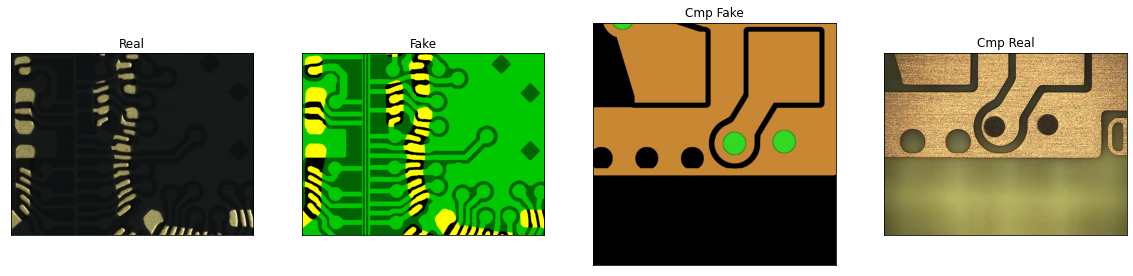

In [8]:
diff_real_path = '/data/home/lunaluo/git/pytorch-CycleGAN-and-pix2pix/util/diff_real.jpeg'
cmp_real_img = Image.open(diff_real_path)
cmp_img = Image.open(comp_path)
cmp_dict = {'cmp_fake': cmp_img, 'cmp_real': cmp_real_img}
images_nanya.update(cmp_dict)
visualize(**images_nanya)

In [9]:
# 统计对比图片的颜色
cmp_colors = Counter(cmp_img.getdata())
cmp_main = cmp_colors.most_common(4)
cmp_main_colors_list = convert_most_colors_to_hsv_list(cmp_main)
cmp_main_colors_list

[[0, 0, 0], [17, 190, 200], [57, 215, 216], [0, 255, 1]]

In [10]:
import copy
#　把从图像中获取到的精确　颜色值　转换到一个range [lower, upper], 去获取mask
def smooth_color_range(color_list, smooth_axis=0, smooth_margin=5):
    new_color_list = []
    for color in color_list:
        color_range = []
        for i in ['lower', 'upper']:
            tmp = copy.copy(color)
            if i == 'lower':
                tmp[smooth_axis] -= smooth_margin
                # print('lower', tmp, color)
            else:
                tmp[smooth_axis] += smooth_margin
                # print('upper', tmp, color)
            color_range.append(np.array(tmp))
        new_color_list.append(color_range)
    return new_color_list

In [11]:
cmp_colors_range_list = smooth_color_range(cmp_main_colors_list) # 获取cmp图片中4个颜色的一个smooth range
cmp_colors_range_list

[[array([-5,  0,  0]), array([5, 0, 0])],
 [array([ 12, 190, 200]), array([ 22, 190, 200])],
 [array([ 52, 215, 216]), array([ 62, 215, 216])],
 [array([ -5, 255,   1]), array([  5, 255,   1])]]

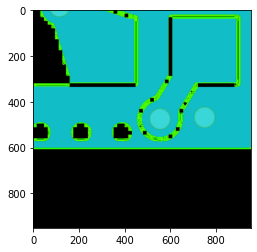

In [12]:
cmp_img_hsv = cv2.cvtColor(np.array(cmp_img), cv2.COLOR_RGB2HSV)
plt.imshow(cmp_img_hsv)

In [13]:
black = cmp_colors_range_list[0]
black_mask = cv2.inRange(cmp_img_hsv, black[0], black[1])
orange = cmp_colors_range_list[1]
orange_mask = cv2.inRange(cmp_img_hsv, orange[0], orange[1])



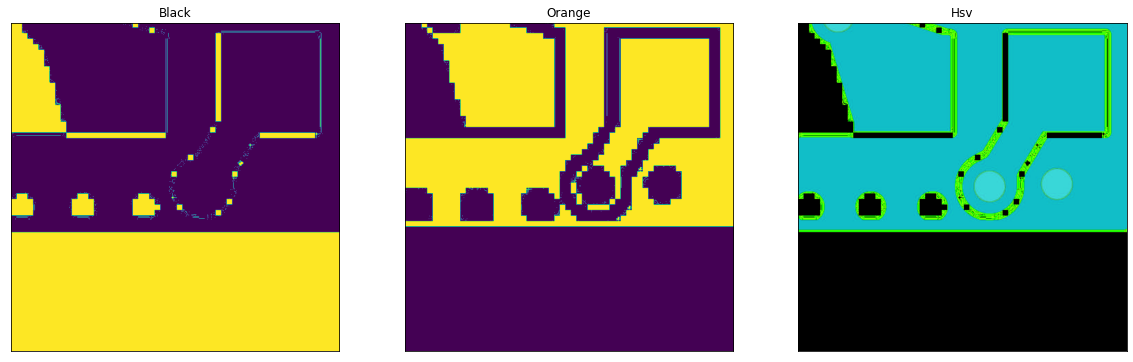

In [14]:
visualize(black=black_mask, orange=orange_mask, hsv=cmp_img_hsv)

In [ ]:
def create_pure_color_img(color, img_size):
    img = np.zeros(img_size, dtype=np.uint8)
    img[:, :, :] = color
    return img.astype(np.uint8)
pure_imgs = {}
cmp_img_copy = copy.deepcopy(cmp_img) #bgr img
for i, color in enumerate(cmp_main_colors_list):
    img = create_pure_color_img(color, img_size=cmp_img_copy.shape)
    pure_imgs[str(i)] = img
pure_imgs['hsv_img'] = cmp_img_hsv
visualize(**pure_imgs)

In [21]:
cmp_img_copy = copy.deepcopy(cmp_img) #bgr img
orange_res= cv2.bitwise_and(np.array(cmp_img_copy), np.array(cmp_img_copy), black_mask)
visualize(black=orange_res[:, :, ::-1], img=cmp_img_copy)

error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'bitwise_and'
> Overload resolution failed:
>  - src1 is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src1'


In [ ]:
black = cmp_main[0][0]
# xs, ys = np.where(cmp_img_copy==black)
# cmp_img_copy[ys, xs, :] =  main_colors[0][0] #黑色 基材 --> 绿色
# cmp_img_copy[cmp_img_copy==np.array(cmp_main[1][0])] = np.array(main_colors[2][0]) #橙色 金面 --> 黄色
# cmp_img_copy[cmp_img_copy==np.array(cmp_main[2][0])] = np.array(main_colors[1][0]) # 绿色 次金面 --> 深绿色
# cmp_img_copy[cmp_img_copy==np.array(cmp_main[3][0])] = np.array(main_colors[1][0]) # 深绿色 次金面边缘 --> 深绿色

# plt.imshow(cmp_img_copy)
cmp_img_copy.shape